## Kaggle House Price Prediction Competition

In this notebook we tackle the Ames, Iowa housing data set. We first clean the data to remove any NaNs that are present before moving on to exploratory data analysis. The final section selects and tunes machine learning models to be deployed on the test set.

I have uploaded a stripped down version of this notebook cotaning only the NaN removal component for others to use if they wish to save themselves time cleaning the data.
* **[Ames, Iowa NaN removal](https://www.kaggle.com/ricksoc/nan-processing-for-ames-iowa-dataset)**

In [1]:
# Import required packages
import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np
np.random.seed(27)
import matplotlib.pyplot as plt
plt.style.use('ggplot')
colours = plt.rcParams['axes.prop_cycle'].by_key()['color']   
%matplotlib inline
import seaborn as sns
sns.color_palette('muted')
current_palette = sns.color_palette()
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import mode, kstest, levene, boxcox, f_oneway

from mlxtend.plotting import plot_confusion_matrix

from sklearn.model_selection import train_test_split

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
#Import data and take a copy for experimenting during exploration

# Import data when working on local machine
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

# Import data for Kaggle notebook
# train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
# test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

test_id = test['Id'] # save id column for indexing final submission
house_test = test.copy()
house_test.drop(['Id'],inplace=True,axis=1)

train_id = train['Id']
house_train = train.copy()
house_train.drop(['Id'],inplace=True,axis=1)

Having loaded the data I will run some basic examinations and descriptive statistics to get a feel for the data before examining what NaNs are present and fixing them.

In [3]:
# Look at the head of the training data frame to see what an observation looks like in this data set
house_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Inspect the numerical columns of the training and test sets to get a feel for the shape of the data
print('Descriptive Statistics for the training data set')
display(house_train.describe().T)

print('\n Descriptive Statistics for the test data set')
display(house_test.describe().T)

Descriptive Statistics for the training data set


,count,mean,std,min,25%,50%,75%,max
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0



 Descriptive Statistics for the test data set


,count,mean,std,min,25%,50%,75%,max
MSSubClass,1459.0,57.378341,42.746880,20.0,20.00,50.0,70.00,190.0
LotFrontage,1232.0,68.580357,22.376841,21.0,58.00,67.0,80.00,200.0
LotArea,1459.0,9819.161069,4955.517327,1470.0,7391.00,9399.0,11517.50,56600.0
OverallQual,1459.0,6.078821,1.436812,1.0,5.00,6.0,7.00,10.0
OverallCond,1459.0,5.553804,1.113740,1.0,5.00,5.0,6.00,9.0
YearBuilt,1459.0,1971.357779,30.390071,1879.0,1953.00,1973.0,2001.00,2010.0
YearRemodAdd,1459.0,1983.662783,21.130467,1950.0,1963.00,1992.0,2004.00,2010.0
MasVnrArea,1444.0,100.709141,177.625900,0.0,0.00,0.0,164.00,1290.0
BsmtFinSF1,1458.0,439.203704,455.268042,0.0,0.00,350.5,753.50,4010.0
BsmtFinSF2,1458.0,52.619342,176.753926,0.0,0.00,0.0,0.00,1526.0


Now I will identify which features in the training and test sets have NaNs present. The documentation provided describing what each feature in the data set means will be useful in understanding which columns might be expected to contain NaNs.
* [Dataset documentation](https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt)

In [5]:
print('Features containing NaNs in test set = {}'.format(house_test.isna().any().sum()))
print('Features containing NaNs in training set = {}'.format(house_train.isna().any().sum()))

na_col_train = house_train.isna().any()
train_na = house_train.loc[:,na_col_train].isna().sum()

na_col_test = house_test.isna().any()
test_na = house_test.loc[:,na_col_test].isna().sum()

display(pd.DataFrame([train_na,test_na],index=['train','test']).T)

Features containing NaNs in test set = 33
Features containing NaNs in training set = 19


,train,test
LotFrontage,259.0,227.0
Alley,1369.0,1352.0
MasVnrType,8.0,16.0
MasVnrArea,8.0,15.0
BsmtQual,37.0,44.0
BsmtCond,37.0,45.0
BsmtExposure,38.0,44.0
BsmtFinType1,37.0,42.0
BsmtFinType2,38.0,42.0
Electrical,1.0,NaN


### NaN removal explained
I have not set out to create an exhaustive process for removing all NaNs from any data set using these features. Rather I have looked to tackle the NaNs missing from these specific training and test sets but generalised where possible.

#### Starting Point
18 features in the training set contain NaNs, 33 features in the test set contain NaNs.

##### Lot Frontage

All dwellings are houses so should have some frontage, i.e. there are no flats which would not have any street connected to the property. I will impute this with the mean frontage for the Neighbourhood of the house.

##### Alley 

NaN for this feature is defined in data description as meaning there is no alley access -> change to "None".

In [6]:
# Inspect Mason Veneer Area and Type NaNs
display((house_train.loc[(house_train['MasVnrArea'].notna()) & (house_train['MasVnrType'].isna())\
                         ,['MasVnrArea','MasVnrType']]).isna().any().sum())
display((house_test.loc[(house_test['MasVnrArea'].notna()) & (house_test['MasVnrType'].isna())\
                         ,['MasVnrArea','MasVnrType']]).isna().any().sum())

display(house_test.loc[(house_test['MasVnrArea'].notna()) & (house_test['MasVnrType'].isna())])

0

1

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1150,20,RL,124.0,27697,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,4,3,1961,1961,Shed,CompShg,Plywood,Plywood,NaN,198.0,TA,TA,CBlock,TA,TA,No,BLQ,811.0,Unf,0.0,585.0,1396.0,GasA,TA,N,SBrkr,1608,0,0,1608,0.0,0.0,1,0,3,1,TA,6,Typ,0,NaN,Attchd,1961.0,Unf,1.0,444.0,TA,Fa,Y,152,38,0,0,0,0,NaN,NaN,NaN,0,11,2007,COD,Abnorml


##### Mason Venner Type and Area

MasVrnType and MasVrnArea have multiple instances where the Area is 0 in which case the Type NaN should be set to 'None'. There is one instance in the test set where an Area is given but no type. This is for record 1150. Inspecting this record the house is made of plywood and the most common Veneer type for Plywood houses when they have one is "BrkFace".

In [7]:
# Inspect single observation with NaN for total basement area
display(house_test.loc[house_test['TotalBsmtSF'].isna()])

#Investigate missing BsmtQual values
display(house_test[(house_test['BsmtQual'].isna()) & (house_test['TotalBsmtSF']>0)])
display(house_train.loc[house_train['Neighborhood']=='IDOTRR'].groupby(['MSZoning','BsmtQual'])\
.agg({'BsmtQual':'count','MSZoning':'count'}))

#Inspecting training set observation with Bsmt2 area but not finish type
display(house_train.loc[house_train['BsmtFinType1']=='GLQ']['BsmtFinType2'].value_counts())

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
660,20,RM,99.0,5940,Pave,NaN,IR1,Lvl,AllPub,FR3,Gtl,BrkSide,Feedr,Norm,1Fam,1Story,4,7,1946,1950,Gable,CompShg,MetalSd,CBlock,None,0.0,TA,TA,PConc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GasA,TA,Y,FuseA,896,0,0,896,NaN,NaN,1,0,2,1,TA,4,Typ,0,NaN,Detchd,1946.0,Unf,1.0,280.0,TA,TA,Y,0,0,0,0,0,0,NaN,MnPrv,NaN,0,4,2008,ConLD,Abnorml


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
757,70,C (all),60.0,5280,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Feedr,Norm,1Fam,2Story,4,7,1895,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,Stone,NaN,Fa,No,Unf,0.0,Unf,0.0,173.0,173.0,GasA,Ex,N,SBrkr,825,536,0,1361,0.0,0.0,1,0,2,1,TA,6,Typ,0,NaN,Detchd,1895.0,Unf,1.0,185.0,Fa,TA,Y,0,123,0,0,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal
758,50,C (all),52.0,5150,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Feedr,Norm,1Fam,1.5Fin,4,7,1910,2000,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,PConc,NaN,TA,No,Unf,0.0,Unf,0.0,356.0,356.0,GasA,TA,N,FuseA,671,378,0,1049,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Detchd,1910.0,Unf,1.0,195.0,Po,Fa,N,0,0,0,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal


BsmtQual  MSZoning
MSZoning BsmtQual                    
C (all)  TA               9         9
RM       Fa               1         1
         Gd               1         1
         TA              25        25

Unf    392
LwQ     10
Rec      9
ALQ      4
BLQ      2
Name: BsmtFinType2, dtype: int64

##### Basement Variables
Test observation 660 has a NaN for TotalBsmtSF. Examining this record it does not appear that there is a basement. I will therefore set TotalBsmtSF to 0 which will allow the other basement feature processing to occur without error.

There are two values in the test set where there is a non-zero TotalBsmtSF area recorded but NA BsmtQual. Both houses
come from the same Neighbourhood and Zoning. Looking at the training set houses with these characteristics have TA BsmtQual
so I will impute as this.

Where there is a total basement area greater than 0 but missing basement quality and/ or condition entries these will be assumed as 'TA', which is the coding for typical quality.

Where the total basement area is zero and qualitative qualitative basement feature values are missing these wil be set to 'None', except for 'BasementExposure' which will be set to 'No' to fit with the convention for this feature.

If a basement has a valid FinType1 and a NaN for FinType to this will be set to 'Unf'.

If total basement SF = 0 and BsmtFinSF1 is NaN then BsmtFinSF1 and BsmtUnfSF will be set to 0.

Missing BsmtFinSF2 will be set to 0.


In [8]:
# Inspect missing value from training set Electrical feature
display(house_train.loc[house_train['Electrical'].isna()])

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1379,80,RL,73.0,9735,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,SLvl,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,384,384,GasA,Gd,Y,NaN,754,640,0,1394,0,0,2,1,3,1,Gd,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2,400,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal,167500


##### Electrical
The house missing this info (training id 1379) has air con which implies it must have electrical. I will impute this as the modal electrical type.

##### FireplaceQu
All NaNs for this feature correspond to the 'Fireplace' feature being 0 so are set to 'None'.

In [9]:
# Investigate missing values in Garage features
# Garage Cars and Garage Area both have a single missing value in the test set only
display(house_test.loc[(house_test['GarageCars'].isna()) | (house_test['GarageArea'].isna())])

# Single test record where year built is 2207
display(house_test.loc[house_test['GarageYrBlt']==2207])

# Check other missing garage values correspond to not having a garage
garage_cols = [col for col in test.columns if 'Garage' in col]
garage_cols.remove('GarageArea')
missing_train_garage = house_train[garage_cols].loc[(house_train['GarageArea']>0)].isna().sum()
missing_test_garage = house_test[garage_cols].loc[(house_test['GarageArea']>0)].isna().sum()
display('Training',missing_train_garage)
display('Test',missing_test_garage)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1116,70,RM,50.0,9060,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,BrkTil,Gd,TA,No,ALQ,548.0,Unf,0.0,311.0,859.0,GasA,Ex,Y,SBrkr,942,886,0,1828,0.0,0.0,2,0,3,1,Gd,6,Typ,0,NaN,Detchd,NaN,NaN,NaN,NaN,NaN,NaN,Y,174,0,212,0,0,0,NaN,MnPrv,NaN,0,3,2007,WD,Alloca


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1132,20,RL,68.0,8298,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,8,5,2006,2007,Hip,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,Av,GLQ,583.0,Unf,0.0,963.0,1546.0,GasA,Ex,Y,SBrkr,1564,0,0,1564,0.0,0.0,2,0,2,1,Ex,6,Typ,1,Gd,Attchd,2207.0,RFn,2.0,502.0,TA,TA,Y,132,0,0,0,0,0,NaN,NaN,NaN,0,9,2007,New,Partial


'Training'

GarageType      0
GarageYrBlt     0
GarageFinish    0
GarageCars      0
GarageQual      0
GarageCond      0
dtype: int64

'Test'

GarageType      0
GarageYrBlt     1
GarageFinish    1
GarageCars      0
GarageQual      1
GarageCond      1
dtype: int64

In [10]:
ind = house_test[garage_cols].index[(house_test['GarageArea']>0) & (house_test['GarageYrBlt'].isna())]
display(house_test.iloc[ind])

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
666,60,RM,57.0,8094,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2.5Unf,6,8,1910,1983,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,PConc,TA,TA,Mn,Rec,196.0,Unf,0.0,1046.0,1242.0,GasA,Gd,Y,SBrkr,1242,742,0,1984,0.0,0.0,2,0,5,1,TA,8,Typ,0,NaN,Detchd,NaN,NaN,1.0,360.0,NaN,NaN,Y,64,0,180,0,0,0,NaN,MnPrv,Shed,1000,9,2008,WD,Normal


##### Garage Variables
Test observation 1116 appears to have a garage but is missing almost all information about it other than it is detached. I have dealt with this as a special case rather than in the main function. To impute the missing values I have grouped houses by their zone and garage type and worked out the modal value for other garage features and input these into test observation 1116.

Test record 666 is responsible for the other anomalous data where there is a non-zero garage area but other garage features record NaNs. I will use the function described above to process record 666 also.

Test observation 1132 has a 'GarageYrBlt' value of 2207. Looking at this record it seems that this should have been 2007 so this has been explicitely corrected.

Other qualitative garage feature NaNs correspond to houses without garages so have been set to 'None'

In [11]:
# Missing pool values
display(house_test.loc[(house_test['PoolArea']>0) & (house_test['PoolQC'].isna())])
display(house_train['PoolQC'].value_counts())

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
960,20,RL,75.0,9532,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,6,1953,1953,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,BLQ,595.0,Rec,354.0,156.0,1105.0,GasA,Gd,Y,SBrkr,1647,0,0,1647,1.0,0.0,1,0,3,1,TA,6,Min1,1,Fa,Attchd,1953.0,Fin,1.0,280.0,TA,TA,Y,225,0,0,0,0,368,NaN,GdPrv,NaN,0,2,2007,WD,Normal
1043,50,RL,104.0,23920,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Feedr,Norm,1Fam,1.5Fin,6,5,1984,1984,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,1105.0,1105.0,GasA,Ex,Y,SBrkr,1105,717,0,1822,0.0,0.0,2,0,4,1,Gd,7,Min2,1,Po,Attchd,1984.0,Unf,2.0,515.0,TA,TA,P,0,195,1012,0,0,444,NaN,NaN,NaN,0,4,2007,WD,Normal
1139,20,RL,200.0,43500,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Artery,Norm,1Fam,1Story,3,5,1953,1953,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,Ex,Y,SBrkr,2034,0,0,2034,0.0,0.0,1,0,2,1,TA,9,Min1,0,NaN,2Types,1953.0,RFn,4.0,1041.0,TA,TA,N,483,266,0,0,0,561,NaN,GdPrv,NaN,0,6,2007,WD,Normal


Gd    3
Fa    2
Ex    2
Name: PoolQC, dtype: int64

##### Pool Quality
There are some Pools which have an area but no quality value. These have been set to Gd as this is the most common quality in the training set (albeit with a small sample size). All other NaNs are 'None'.

##### Fence
NaNs are assumed as not having a fence so set to 'None'.

##### Misc Feature
NaNs set to 'None'.

##### MSZoning
MSZoning - all hosues must be zoned, impute as modal zone type.

##### Utilities
All houses should have some utility access so this has been imputed as the modal value for the feature.

##### Exterior Covering
I have assumed that houses in the same neighbourhood have similar styles and that all houses have some exterior covering. NaNs have been imputed as the modal type for their neighbourhood.

##### Kitchen Quality
Where a kitchen is present but has a NaN for quality these has been set to typical 'TA'.

##### Functionality
NaNs for this feature have been set to 'Typ' as this fits with the most common entry and likelihood based on feature description.

##### Sale Type
NaNs set to 'WD' as the most likely value.

In [12]:
#Process NaNs in training and test data frames

#Deal with Garage NaNs in test record 1116 of the test set
garage_cols = [col for col in test.columns if 'Garage' in col]
garage_cols.remove('GarageType')
garage_groups = house_train.groupby(['MSZoning','GarageType'])[garage_cols].agg(lambda x: mode(x)[0])

def fill_row_na(input_df,row,fill_group):
    '''function to fill in missing values for a particular dataframe row using a groupby object created outside the function'''
    df = input_df.copy() # take copy of data frame so as not to double modify
    zone = df.iloc[row,df.columns.get_loc("MSZoning")]
    gtype = df.iloc[row,df.columns.get_loc('GarageType')]
    fill_group = fill_group.loc[zone,gtype]
    for ind, item in fill_group.iteritems():
        if np.isnan(df.loc[row,ind]):
            df.loc[row,ind] = item
    return df

house_test = fill_row_na(house_test,1116,garage_groups)
house_test = fill_row_na(house_test,666,garage_groups)

#Correct GarageYrBlt = 2207 in test set
house_test.loc[1132,'GarageYrBlt'] = 2007

#Test set record 660 creates a specific problem as it records a NaN for TotalBsmtSF. Setting this to 0 will allow
#the na_processing function below to handle the other NaNs
house_test.loc[house_test['TotalBsmtSF'].isna(),'TotalBsmtSF'] = 0

#One test observation has a veneer area but no type, set this to BrkFace as it best fits the other
house_test.loc[(house_test['Neighborhood']=='Mitchel') & (house_test['MasVnrArea']>0),'MasVnrType'] = 'BrkFace'

def na_processing(input_df,training):
    '''Function for processing remaining NaNs in training and test data sets. Values are either imputed, or set to 0 or None'''
    
    df = input_df.copy() # take copy of dataframe to avoid modifying the original other than with function call
    
    #Lot Frontage
    lot_frontage_fill = training.groupby('Neighborhood').agg({'LotFrontage':'mean'})
    df = df.set_index('Neighborhood')
    df['LotFrontage'].fillna(lot_frontage_fill['LotFrontage'],inplace=True)
    df = df.reset_index()
    
    #Alley
    df['Alley'].fillna('None',inplace=True)
    
    #Masonary Veneer Area and Typr
    df['MasVnrArea'].fillna(0,inplace=True)
    df['MasVnrType'].fillna('None',inplace=True)
    
    #Basement Variables
    df.loc[(df['TotalBsmtSF']>0) & (df['BsmtQual'].isna()) ,'BsmtQual'] = 'TA'
    
    df.loc[(df['TotalBsmtSF']>0) & (df['BsmtCond'].isna()),'BsmtCond'] = 'TA'
    
    df.loc[df['TotalBsmtSF']==0,['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']] = \
    df.loc[df['TotalBsmtSF']==0,['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']].fillna('None')
    
    df.loc[(df['TotalBsmtSF']>0) & (df['BsmtExposure'].isna()),'BsmtExposure'] = 'No'
    
    df.loc[(df['BsmtFinType1'].notna()) & (df['BsmtFinType2'].isna()),'BsmtFinType2'] = 'Unf'
    
    df.loc[(df['TotalBsmtSF']==0) & (df['BsmtFinSF1'].isna()),['BsmtFinSF1','BsmtUnfSF']] = 0
    
    df['BsmtFinSF2'].fillna(0,inplace=True)
    
    df.loc[:,['BsmtFullBath','BsmtHalfBath']] = df.loc[:,['BsmtFullBath','BsmtHalfBath']].fillna(0)

    #Electrical
    df['Electrical'].fillna(training['Electrical'].mode()[0],inplace=True)
    
    #Fireplace Quality
    df['FireplaceQu'].fillna('None',inplace=True)
    
    #Garage Variables
    garage_cols = [col for col in df.columns if 'Garage' in col]
    garage_cols.remove('GarageCars')
    garage_cols.remove('GarageArea')
    df.loc[:,garage_cols] = df.loc[:,garage_cols].fillna('None')
    
    #Pool Quality
    df.loc[(df['PoolArea']>0) & (df['PoolQC'].isna()),'PoolQC'] = 'Gd'
    df['PoolQC'].fillna('None',inplace=True)
    
    #Fence
    df['Fence'].fillna('None',inplace=True)
    
    #Misc Feature
    df['MiscFeature'].fillna('None',inplace=True)
    
    #MS Zoning
    df['MSZoning'].fillna(training['MSZoning'].mode()[0],inplace=True)

    #Utilities
    df['Utilities'].fillna(training['Utilities'].mode()[0],inplace=True)
    
    #Exterior Covering
    exterior_fill = training.groupby('Neighborhood').agg({'Exterior1st': lambda x: mode(x)[0],\
                                                        'Exterior2nd': lambda x: mode(x)[0]})
    
    df = df.set_index('Neighborhood')
    df['Exterior1st'].fillna(exterior_fill['Exterior1st'],inplace=True)
    df['Exterior2nd'].fillna(exterior_fill['Exterior2nd'],inplace=True)
    df = df.reset_index()
    
    #Kitchen Quality
    df.loc[(df['KitchenAbvGr']>0) & (df['KitchenQual'].isna()),'KitchenQual'] = 'TA'
    
    #Functionality
    df['Functional'].fillna('Typ',inplace=True)
    
    #Sale Type
    df['SaleType'].fillna('WD',inplace=True)
       
    return df

test_processed = na_processing(house_test,house_train)
train_processed = na_processing(house_train,house_train)


print('Features containing NaNs in test set = {}'.format(test_processed.isna().any().sum()))
print('Features containing NaNs in training set = {}'.format(train_processed.isna().any().sum()))

Features containing NaNs in test set = 0
Features containing NaNs in training set = 0


In [13]:
# Save data frames with NaNs removed
test_clean = pd.concat([test_id,test_processed],axis=1)
train_clean = pd.concat([train_id,train_processed],axis=1)

test_clean.to_csv('test_clean.csv')
train_clean.to_csv('train_clean.csv')

In [14]:
# Clean up data artefacts created during NaN cleaning
del [na_col_train, na_col_test, train_na, test_na, missing_train_garage, missing_test_garage, garage_groups\
     , house_train, house_test]

### EDA
Having cleaned the data of NaNs I will now dig deeper to understand which features are likley to be of use in machine learning models (feature selection) and whether there are combinations of, or derivations from, the features which will yield more predictive information, or more efficient predictive information, on the target feature (feature engineering).

From now on I will observe the discipline of only looking at the training set. I will further split the cleaned training data into a true training set and a validation set to be used for hyperparamter turning.

(1168, 79)

(292, 79)

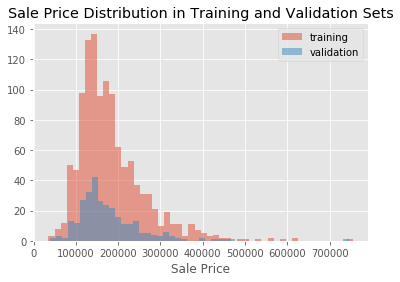

In [15]:
# Create training and validation sets.
house_train = train_clean
house_test = test_clean

X_train, X_valid, y_train, y_valid = train_test_split(house_train.drop('SalePrice',axis=1),\
                                            house_train['SalePrice'], test_size=0.2, random_state=27)

X_train.drop('Id',inplace=True,axis=1) #drop Id columns as they are not needed
X_valid.drop('Id',inplace=True,axis=1)

display(X_train.shape,X_valid.shape) # Check shape of training and validation data sets

# Use rough eyeball test to check that the validation target set is representative of the training set  
plt.hist(y_train, bins=50, alpha=0.5, label='training')
plt.hist(y_valid, bins=50, alpha=0.5, label='validation')
plt.legend(loc='upper right')
plt.xlabel('Sale Price')
plt.title('Sale Price Distribution in Training and Validation Sets')
plt.show()

# Recombine features and target for EDA and model tuning purposes
df_train = pd.concat([X_train,y_train],axis=1)
df_valid = pd.concat([X_valid,y_valid],axis=1)

The distribution of the training and validation sets looks similar and looks to have a right skew which should be investigated further. First I will look at how well correlated the numerical features of the data set are with the sale price. The categorical features will require some further processing before they can be checked in the same way.

Sale Price Skew = 1.79
Sale Price Kurtosis = 5.68
Log Skew = 0.14
Log Kurtosis = 0.66


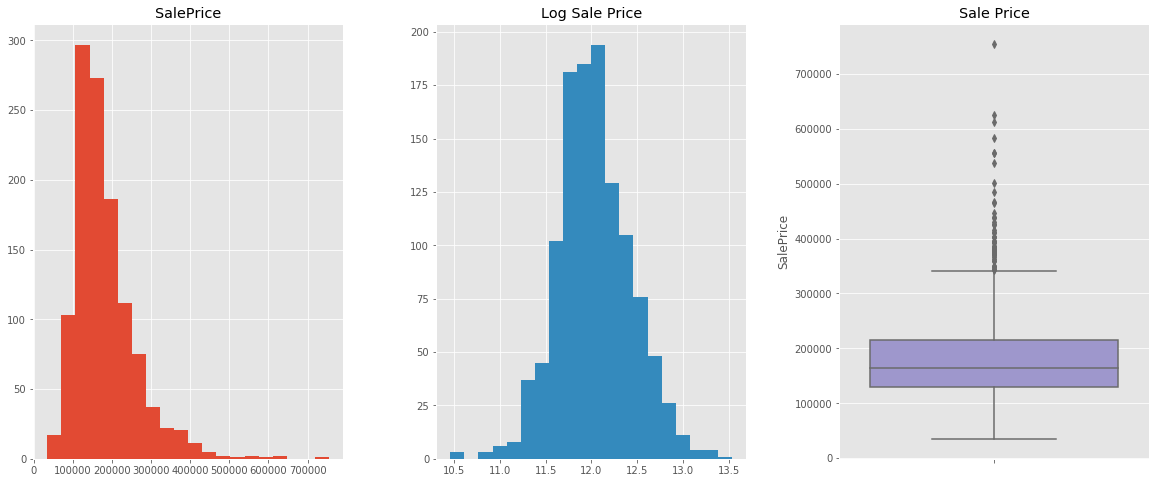

In [16]:
# Look at whether the Sale Price should be log transformed
fig, ax = plt.subplots(1,3,figsize=(20,8))
df_train.hist(column='SalePrice',bins=20,ax=ax[0],color=colours[0])

print('Sale Price Skew = {:.2f}'.format(df_train['SalePrice'].skew()))
print('Sale Price Kurtosis = {:.2f}'.format(df_train['SalePrice'].kurtosis()))

sale_price_log = np.log(df_train['SalePrice'])
ax[1].hist(sale_price_log,bins=20,color=colours[1])
ax[1].set_title('Log Sale Price')
print('Log Skew = {:.2f}'.format(sale_price_log.skew()))
print('Log Kurtosis = {:.2f}'.format(sale_price_log.kurtosis()))

_ = sns.boxplot(y='SalePrice',data=df_train,ax=ax[2],color=colours[2]).set_title('Sale Price')


The Sale Price target is normally distributed though in its base form is right-tail skewed. Taking the log of Sale Price corrects this so it may help the model to predict log Sale Price and then take the exponential to create the final predictions.

There are two clear outliers which should probably be removed from the training set before modelling.

In [41]:
# Look at how taking the log of the sale price affects feature correlation. Also examine skewness and kurtosis of the features.
df_train['Log_SalePrice'] = np.log(df_train['SalePrice'])
log_correlation = df_train.corr()['Log_SalePrice']
correlation = df_train.corr()['SalePrice'].sort_values(ascending=False)
kurt = df_train.kurtosis()
skew = df_train.skew()

log_train_correlation = pd.concat([correlation,log_correlation,kurt,skew],axis=1)
log_train_correlation.rename(columns={'Log_SalePrice':'Log_Price_Correlation','SalePrice':'Price_Correlation',\
                                     0:'Kurtosis',1:'Skewness'},inplace=True)
log_train_correlation.drop('Log_SalePrice',inplace=True)

display(log_train_correlation.head(10))

,Price_Correlation,Log_Price_Correlation,Kurtosis,Skewness
SalePrice,1.000000,0.950994,5.682155,1.792170
OverallQual,0.799199,0.828538,0.141316,0.179798
GrLivArea,0.701876,0.700520,4.847595,1.340059
GarageCars,0.643687,0.679342,0.184429,-0.394936
ExterQual,0.617900,0.637681,-1.727727,0.524628
GarageArea,0.615981,0.640132,0.924022,0.139284
TotalBsmtSF,0.614481,0.613459,14.927309,1.679138
1stFlrSF,0.599165,0.586878,6.663983,1.478271
FullBath,0.565718,0.597066,-0.750681,-0.014070
TotRmsAbvGrd,0.536014,0.537885,0.764614,0.653288


Taking the log of the Sale Price improves the correlation factor of most nuerical variables, including nine of the top 10, without changing their order. This implies that using the log of the Sale Price may improve model accuracy, particularly in simpler models. I will continue to do base EDA using the Sale Price as this is the real-world value but may use its log in model buidling.

In [18]:
# Create dictionary of data types by column in training set
type_dict = {str(k) : list(v) for k,v in X_train.groupby(df_train.dtypes,axis=1)}
for k,v, in type_dict.items():
    print(k, len(v))
display(df_train.loc[:,type_dict['float64']].head(10))

# The features classed as float will not lose an important level of detail by being recast as int64
df_train = df_train.astype({"LotFrontage": np.int64, "MasVnrArea": np.int64})
df_valid = df_valid.astype({"LotFrontage": np.int64, "MasVnrArea": np.int64})
house_test = house_test.astype({"LotFrontage": np.int64, "MasVnrArea": np.int64})

int64 33
float64 2
object 44


,LotFrontage,MasVnrArea
1128,59.000000,0.0
749,50.000000,0.0
1313,108.000000,165.0
1006,76.462366,0.0
590,64.000000,0.0
733,80.000000,0.0
247,75.000000,0.0
243,75.000000,0.0
1115,93.000000,328.0
177,74.437500,0.0


### Categorical Feature

With two distinct groups of features I will first look at the object/ categorical set. While some models, e.g. decision trees, would be able to use these fields in their basic form in order to open up a wider set of models these features will need some processing. Dummy encoding is the most likely option, though it may be possible to map some ordinal fields to numeric values if there is confidence that the resulting intervals would be valid.

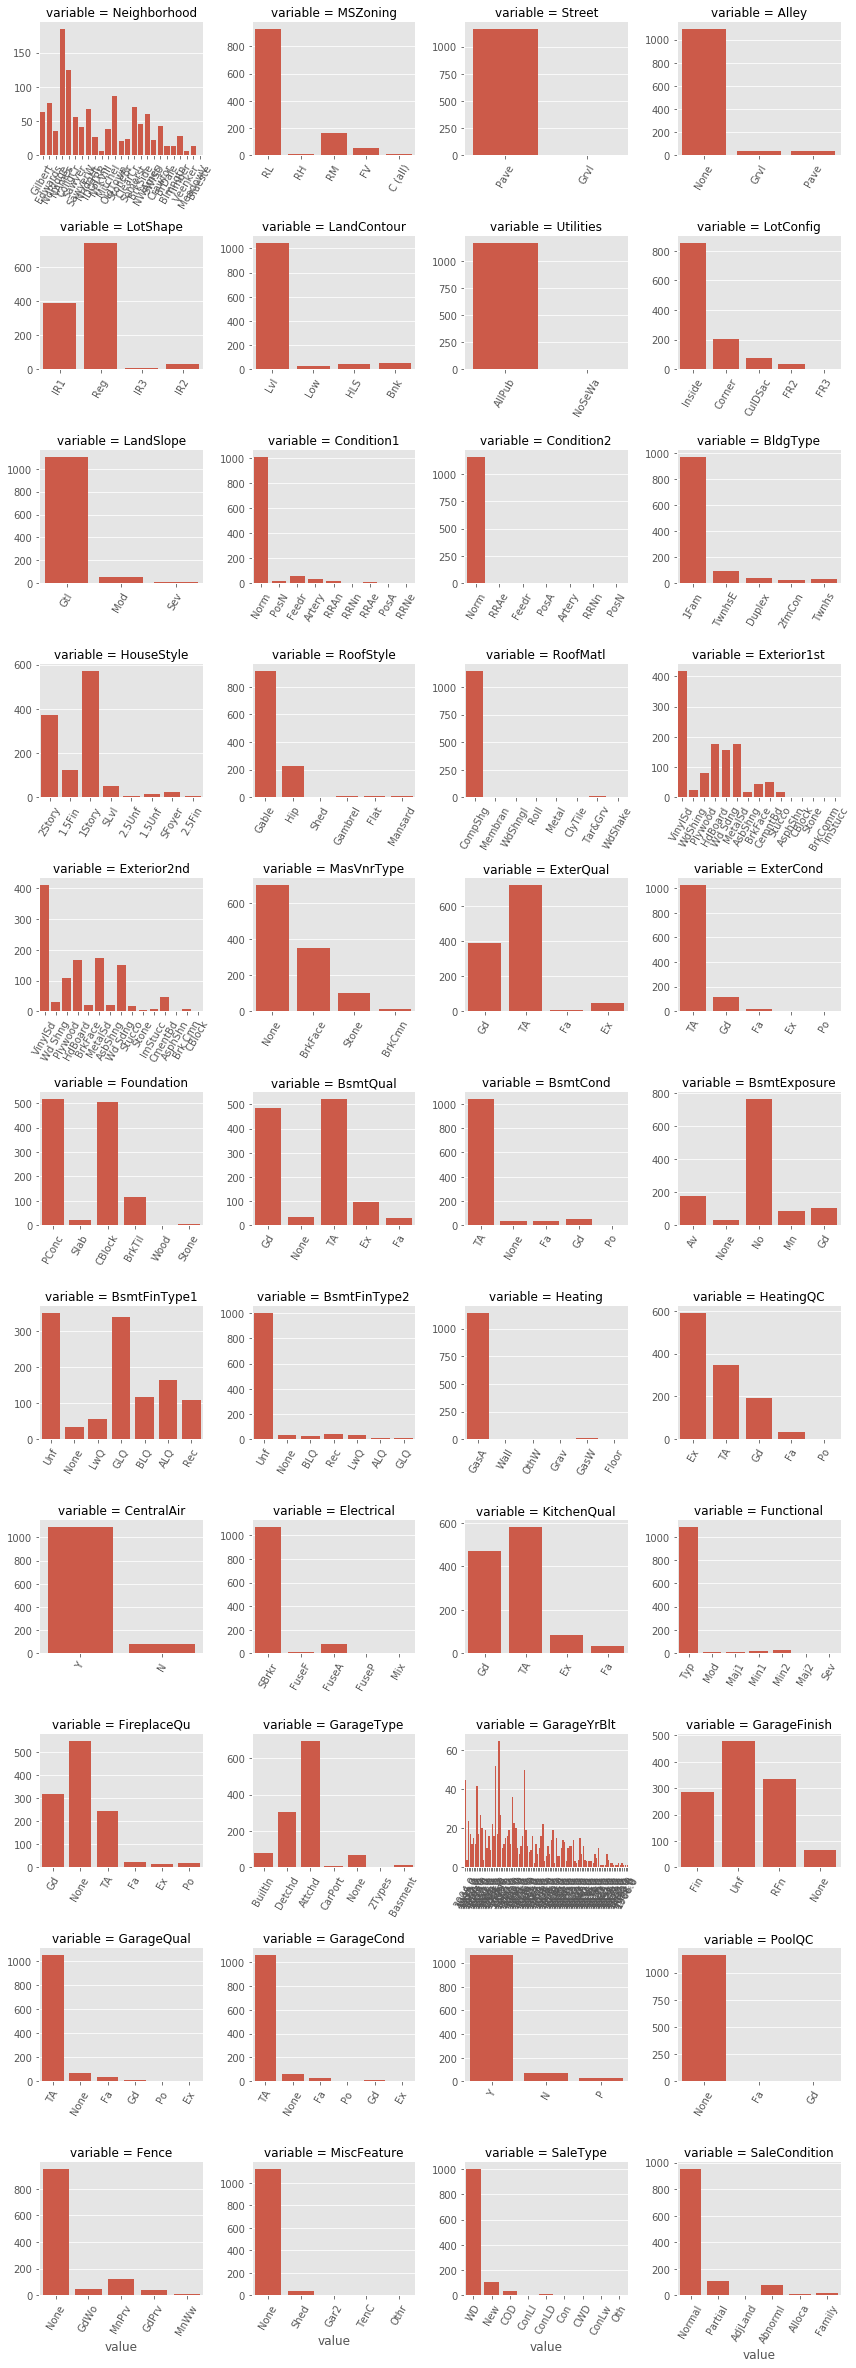

In [19]:
# Examine distribution of all categorical features
cat_features = pd.melt(df_train.loc[:,type_dict['object']], value_vars=type_dict['object'])
fig = sns.FacetGrid(cat_features, col='variable', col_wrap=4, sharex=False, sharey=False)
plt.xticks(rotation='vertical')
fig = fig.map(sns.countplot, 'value')
[plt.setp(ax.get_xticklabels(), rotation=60) for ax in fig.axes.flat]
fig.fig.tight_layout()
plt.show()

Dummy encode each categorical feature in turn then measure the correlation with the sale price. This will tell us which features under a univariate analysis are useful predictors.

In [20]:
# Look at feature category correlations with Log_SalePrice
df_features = df_train.loc[:,type_dict['object']]
max_correlation = []

for col in df_features.columns:
    # set up dummy variables for each categorical feature column in sequence
    dummies = pd.get_dummies(df_train[col])
    dummies = pd.concat([df_train['Log_SalePrice'],dummies],axis=1)
    # find the maximum correlation of any categoriy in the feature
    max_corr = dummies.corr()['Log_SalePrice'][1:].abs().max()
    max_correlation.append(max_corr)
    

feature_correlations = pd.DataFrame({'Features':df_features.columns,'Correlation':max_correlation})
feature_correlations = feature_correlations.loc[feature_correlations['Correlation']>0.3]\
        .sort_values(['Correlation'],ascending=False)

#### ANOVA
As well as how well correlated an individual categorical feature is we can also test to see how much of the variance in Sale Price each categorical feature explains. Combining these two insights will point to which features are most likely to be useful and how to process them.

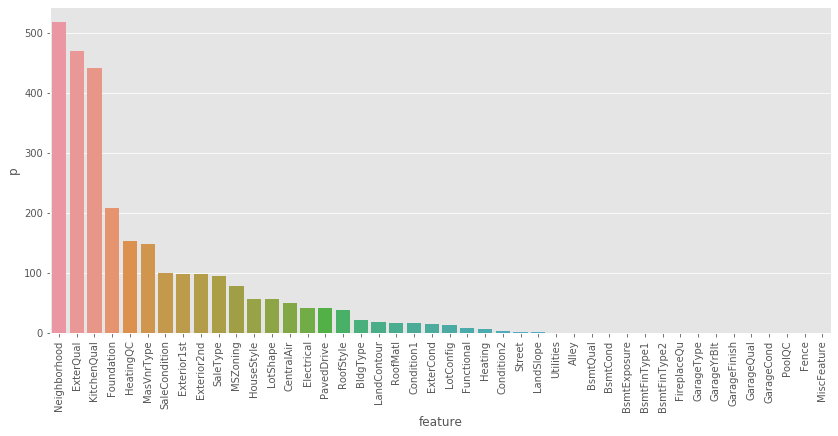

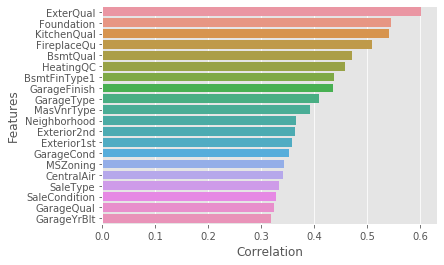

In [21]:
anova = {'feature':[], 'f':[], 'p':[]}
for feature in df_train.select_dtypes(include=['object']).columns: #better way of selecting features by dtype
    category_prices = []
    for category in df_train[feature].unique():
        category_prices.append(train[train[feature] == category]['SalePrice'].values)
    f, p = f_oneway(*category_prices)
    anova['feature'].append(feature)
    anova['f'].append(f)
    anova['p'].append(p)
anova = pd.DataFrame(anova)
anova.sort_values('p', inplace=True)

# Plot
plt.figure(figsize=(14,6))
sns.barplot(anova['feature'], np.log(1/anova['p']))
plt.xticks(rotation=90)
plt.show()

_ = sns.barplot(feature_correlations['Correlation'],feature_correlations['Features'], orient='h')

Neighborhood, ExterQual, KitchenQual, Foundation, HeatingQC and MasVnrType all have a significant p-value and a single categoriy with a relatively high correlation to sale price.

#### Exterior Quality and Kitchen Quality
The Exterior Quality feature has four possible categories and the highest single correlated observation type of any categorical feature.

In [22]:
# Examine correlations of each observation type by dummy enociding
ext_dummies = pd.get_dummies(df_train['ExterQual'])
ext_dummies = pd.concat([df_train['Log_SalePrice'],ext_dummies],axis=1)
ext_corr = ext_dummies.corr()['Log_SalePrice'][1:]

display(ext_corr, df_train['ExterQual'].value_counts())

Ex    0.386170
Fa   -0.172818
Gd    0.494735
TA   -0.602071
Name: Log_SalePrice, dtype: float64

TA    722
Gd    390
Ex     46
Fa     10
Name: ExterQual, dtype: int64

The categories in ExterQual are not evenly soaced in terms or correlation so shouldn't just be interval encoded. TA and Gd dominate and interestingly Ex has a lower positive correlation than Gd. I will try the approach of grouping the positively and negatively correlation types together.

In [23]:
# Group ExterQuals into only two categories and recheck correlation.
df_train['ExterQualRed'] = df_train['ExterQual'].replace({'Ex':1,'Gd':1,'Fa':0,'TA':0})

ext_qual = df_train[['Log_SalePrice','ExterQualRed']]
ext_corr = ext_qual.corr()['Log_SalePrice'][1:]

display(ext_corr)


ExterQualRed    0.637681
Name: Log_SalePrice, dtype: float64

In [24]:
# Repeat analysis above for KitchenQual
ext_dummies = pd.get_dummies(df_train['KitchenQual'])
ext_dummies = pd.concat([df_train['Log_SalePrice'],ext_dummies],axis=1)
ext_corr = ext_dummies.corr()['Log_SalePrice'][1:]

display(ext_corr, df_train['KitchenQual'].value_counts())

# Group ExterQuals into only two categories and recheck correlation.
df_train['KitchenQualRed'] = df_train['KitchenQual'].replace({'Ex':1,'Gd':1,'Fa':0,'TA':0})

ext_qual = df_train[['Log_SalePrice','ExterQualRed','KitchenQualRed']]
ext_corr = ext_qual.corr()

display(ext_corr)

Ex    0.421987
Fa   -0.214046
Gd    0.402365
TA   -0.541723
Name: Log_SalePrice, dtype: float64

TA    582
Gd    471
Ex     83
Fa     32
Name: KitchenQual, dtype: int64

,Log_SalePrice,ExterQualRed,KitchenQualRed
Log_SalePrice,1.000000,0.637681,0.612409
ExterQualRed,0.637681,1.000000,0.720320
KitchenQualRed,0.612409,0.720320,1.000000


ExterQual and KitchenQual can both be usefully processed into a binary feature with good correlation, though with some risk of adversely influencing some low frequency cases. 

However, they are highly correlated with each other so only one of them should be included. I will choose ExterQual as it has the higher correlation and lower p-value.

#### Foundation
Foundation has six categories though the value counts are heavily dominated by two of them. It should hopefully be able to again reduce which of the categories need to be considered.

In [25]:
# Examine correlations of each observation type by dummy enociding
ext_dummies = pd.get_dummies(df_train['Foundation'])
ext_dummies = pd.concat([df_train['Log_SalePrice'],ext_dummies],axis=1)
ext_corr = ext_dummies.corr()['Log_SalePrice'][1:]

display(ext_corr, df_train['Foundation'].value_counts())

BrkTil   -0.249294
CBlock   -0.342748
PConc     0.545171
Slab     -0.184970
Stone    -0.017368
Wood     -0.011652
Name: Log_SalePrice, dtype: float64

PConc     518
CBlock    506
BrkTil    115
Slab       22
Stone       6
Wood        1
Name: Foundation, dtype: int64

The CBlock foundation type has a stronger correlation than any other category so I will binary encode this feature with 1 for CBlock else 0.

#### FireplaceQu, MasVrnType, Neighborhood

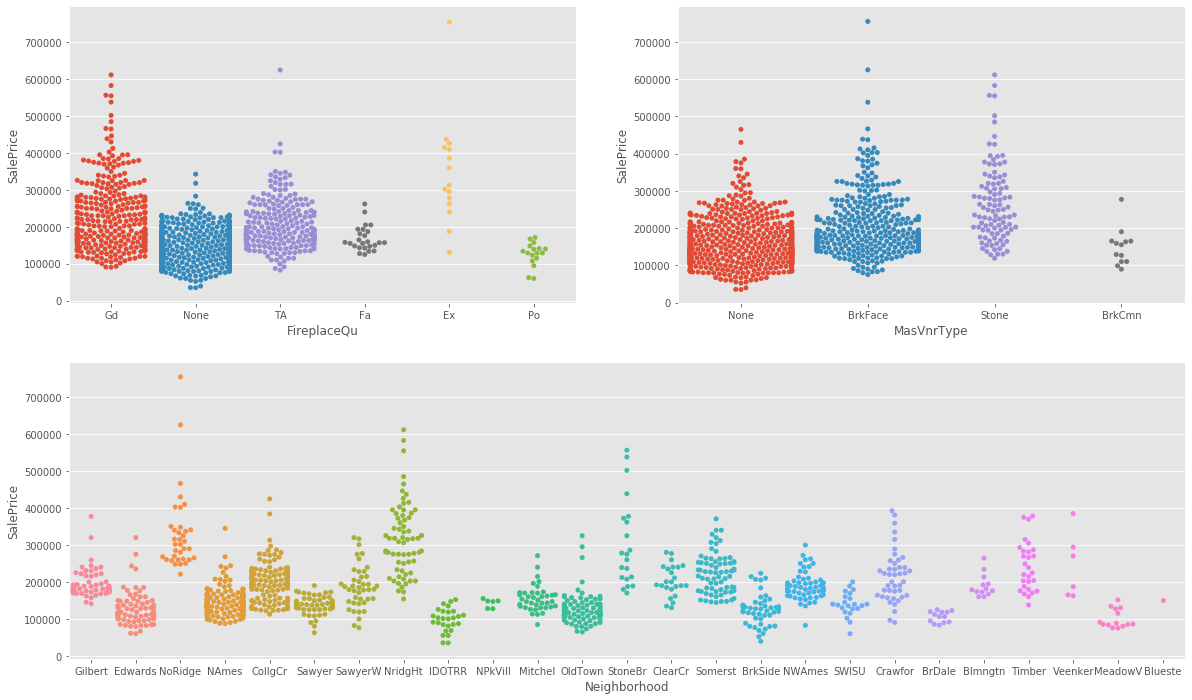

In [26]:
plt.figure(figsize=(20,12))

ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1)
ax2 = plt.subplot2grid((2, 2), (0, 1), colspan=1)
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)

_ = sns.swarmplot(x='FireplaceQu',y='SalePrice',data=df_train,ax=ax1)
_ = sns.swarmplot(x='MasVnrType',y='SalePrice',data=df_train,ax=ax2)
_ = sns.swarmplot(x='Neighborhood',y='SalePrice',data=df_train,ax=ax3)

The primary difference in FireplaceQu and MasVnrType seems to be around whether or not the value is recorded as 'None' so I will create a new feature to capture this.

For neighbourhood there is too much going on and given it's low p-value I will just create a full dummy encoding.

I will now look at these features for multicolineraity.

In [27]:
#Check new binary features for multicolinearity
df_train['FoundationRed'] = np.where(df_train['Foundation']=='PConc',1,0)
df_train['HasFireplace'] = np.where(df_train['FireplaceQu']=='None',0,1)
df_train['MasVnrRed'] = np.where(df_train['MasVnrType']=='None',0,1)

ext_qual = df_train[['Log_SalePrice','ExterQualRed','KitchenQualRed','FoundationRed','HasFireplace','MasVnrRed']]
ext_corr = ext_qual.corr()
display(ext_corr[1:])

,Log_SalePrice,ExterQualRed,KitchenQualRed,FoundationRed,HasFireplace,MasVnrRed
ExterQualRed,0.637681,1.000000,0.720320,0.647183,0.279951,0.305275
KitchenQualRed,0.612409,0.720320,1.000000,0.591224,0.259023,0.260751
FoundationRed,0.545171,0.647183,0.591224,1.000000,0.170844,0.217488
HasFireplace,0.509401,0.279951,0.259023,0.170844,1.000000,0.215748
MasVnrRed,0.391169,0.305275,0.260751,0.217488,0.215748,1.000000


In [28]:
#Clean up added feature. Final processing will be done on main feature column feature
df_train.drop(['ExterQualRed','KitchenQualRed','FoundationRed','HasFireplace','MasVnrRed'],axis=1,inplace=True)

ExterQual, KitchenQual and having a PConc foundation are more highly correlated with each other than with the Sale Price. I will therefore only include one of these in the final model. I will choose ExterQual as it has the lowest p-value and highest correlation.

#### Categorical Feature Processing
Having identified the most promising categorical features to use as predictors these now need to be processed into a useable ML format in the trainig, test and validation dataframes.

In [30]:
def create_cat_features(df):
    df['ExterQual'] = df['ExterQual'].replace({'Ex':1,'Gd':1,'Fa':0,'TA':0}).astype(np.int64)
    df['HasFireplace'] = np.where(df['FireplaceQu']=='None',0,1).astype(np.int64)
    df['MasVnr'] = np.where(df['MasVnrType']=='None',0,1).astype(np.int64)
    
    df_dummies = pd.get_dummies(df['Neighborhood'],prefix='Neighborhood')
    df = pd.concat([df,df_dummies],axis=1)
    
    return df

df_train = create_cat_features(df_train)
df_valid = create_cat_features(df_valid)
house_test = create_cat_features(house_test)

### Numerical Features


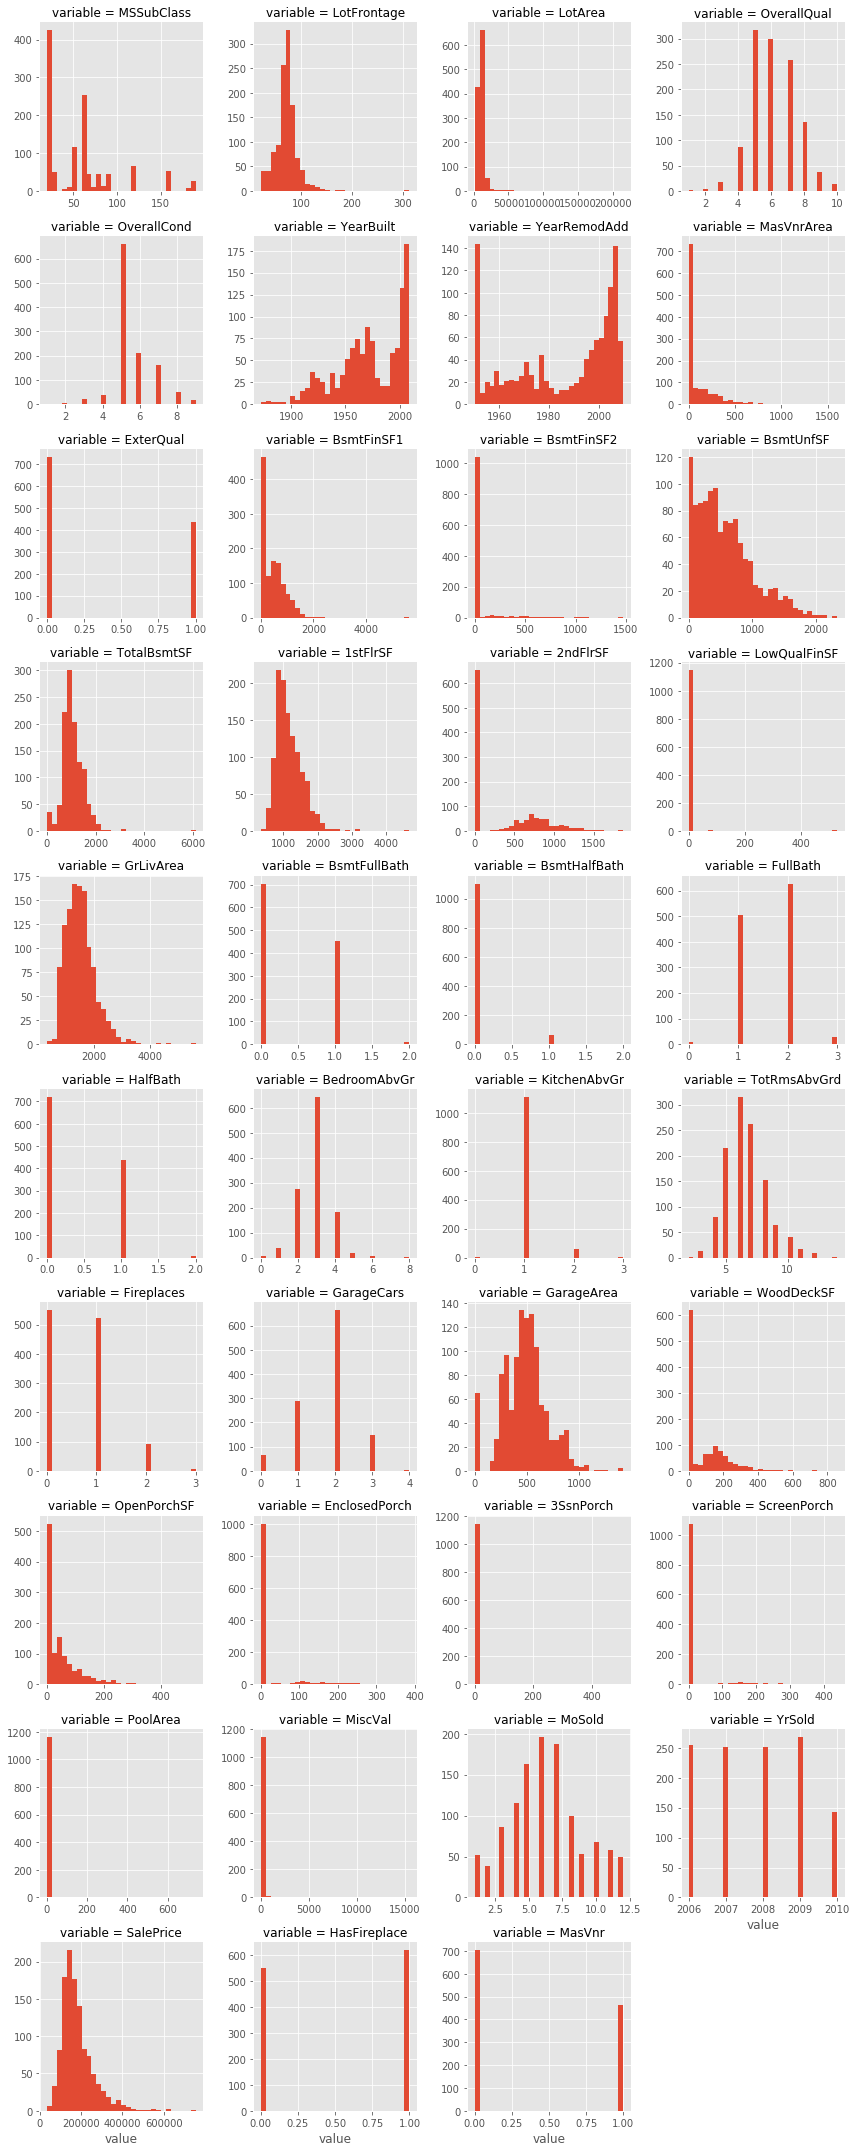

In [34]:
# Examine distribution of all numerical features
num_features = pd.melt(df_train.select_dtypes(include='int64'), value_vars=type_dict['int64'])
fig = sns.FacetGrid(num_features, col='variable', col_wrap=4, sharex=False, sharey=False)
fig = fig.map(plt.hist,'value',bins=30)

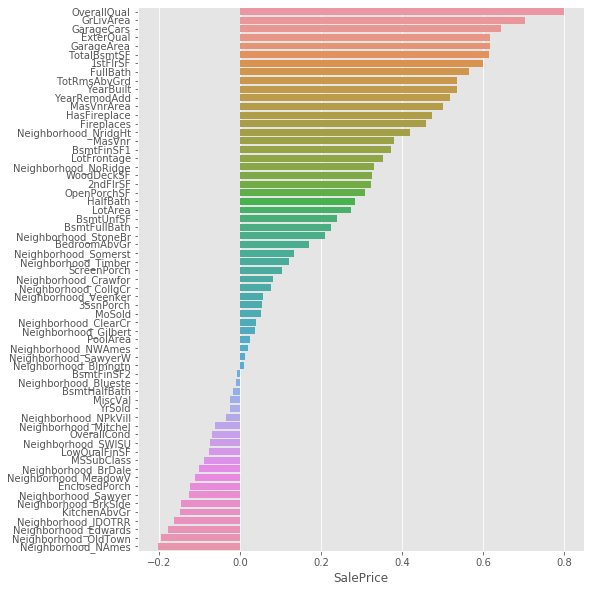

In [35]:
# Inspect numerical columns for correlation to sale price
correlation = df_train.corr()['SalePrice'].sort_values(ascending=False)

plt.figure(figsize=(8,10))
sns.barplot(correlation[2:], correlation.index[2:], orient='h')
plt.show()

#### Overall Quality
The feature most highly correlated with sale price is the Overall Quality. Analysing this in conjunction with the Overall Condition might be instructive.

,Price_Correlation,Log_Price_Correlation,Kurtosis,Skewness
OverallQual,0.799199,0.828538,0.141316,0.179798
OverallCond,-0.069796,-0.026345,1.279265,0.664987


OverallQual,1,2,3,4,5,6,7,8,9,10
Sale Price Variance,235445000.0,2.031822e+08,4.182978e+08,6.202061e+08,6.272315e+08,1.366974e+09,1.960527e+09,3.961929e+09,6.968745e+09,2.449280e+10


Levene test of OverallQual and Sale Price = LeveneResult(statistic=1046.5028814095758, pvalue=5.303402068533137e-190)
Levene test of OverallQual and Log Sale Price = LeveneResult(statistic=808.7824768447198, pvalue=5.247211353481456e-153)


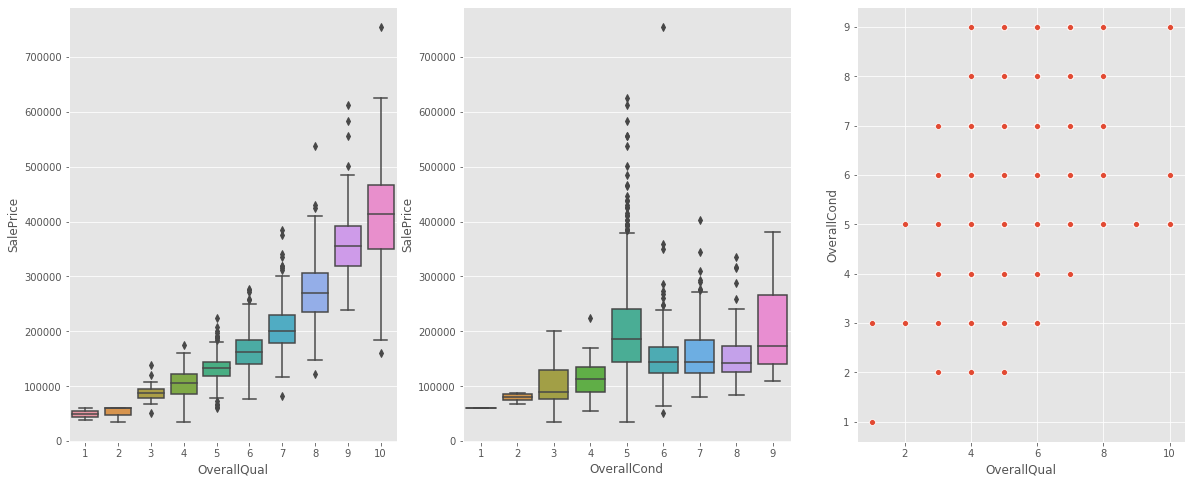

In [36]:
# Examine Overall Quality and Condition
fig, ax = plt.subplots(1,3,figsize=(20,8))
sns.boxplot(x='OverallQual',y='SalePrice',data=df_train,ax=ax[0])
sns.boxplot(x='OverallCond',y='SalePrice',data=df_train,ax=ax[1])
sns.scatterplot(x='OverallQual',y='OverallCond',data=df_train,ax=ax[2])

QualCon = log_train_correlation.loc[['OverallQual','OverallCond']]
display(QualCon)

Qual_var = df_train.groupby('OverallQual').agg({'SalePrice':'var'}).rename(columns={'SalePrice':'Sale Price Variance'})
display(Qual_var.T)

print('Levene test of OverallQual and Sale Price = {}'.format(levene(df_train['OverallQual'],df_train['SalePrice'])))
print('Levene test of OverallQual and Log Sale Price = {}'.format(levene(df_train['OverallQual'],df_train['Log_SalePrice'])))

There is clearly heteroscedasticity present is the house price as the price increases. Further transformation of the feature might reduce this but at the cost of model interpretability and ease of converting the final model output back into a $ figure. I will therefore proceed with using the log of the Sale Price and accept the heteroscedasticity.

Overall Condition does not have a high correlation with Sale Price and what correlation there is in the inverse of Overall Quality so combining these will not produce a useful feature.

I will remove the outliers with a Sale Price in excess of $700,000 from the training set. In a real life situation it would be important to understand how important to the client it was to factor in very high sale prices.

In [ ]:
# Remove outlier sale prices
df_train.drop(df_train.loc[df_train['SalePrice']>700000].index,inplace=True)
_ = df_train.hist(column='SalePrice',bins=20,color=colours[2],alpha=0.7)

In [56]:
# Useful code snippet, do not delete until written in book
# pd.Series([df_train[c].value_counts().index[0] for c in df_train],index=df_train.columns)

#### GrLivArea
The feature with the highest correlation to sale price after overall quality is 'GrLivArea'. Other features which may work well with this are 'LotArea' and 'TotalBsmtSF' to give an overall size feature and 'TotRmsAbvGrd', 'FullBath' and 'HalfBath' which can be combined to give the total number of (non) basement rooms in the house.

,Price_Correlation,Log_Price_Correlation,Kurtosis,Skewness
GrLivArea,0.701876,0.700520,4.847595,1.340059
TotalBsmtSF,0.614481,0.613459,14.927309,1.679138
FullBath,0.565718,0.597066,-0.750681,-0.014070
TotRmsAbvGrd,0.536014,0.537885,0.764614,0.653288
HalfBath,0.284271,0.314718,-1.170103,0.626791
LotArea,0.272555,0.260601,252.715865,13.337475


Text(0, 0.5, 'LotArea')

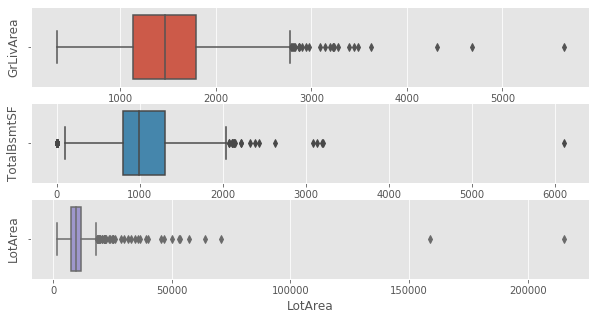

In [57]:
# Inspect Living Area related features
display(log_train_correlation.loc[['GrLivArea','TotalBsmtSF','LotArea','TotRmsAbvGrd','FullBath','HalfBath']].\
       sort_values('Log_Price_Correlation',ascending=False))

# Box Plots of continuous variables
fig, ax = plt.subplots(3,1,figsize=(10,5))
sns.boxplot(y='GrLivArea',data=df_train,ax=ax[0],orient='h',color=current_palette[0]).set_ylabel('GrLivArea')
sns.boxplot(y='TotalBsmtSF',data=df_train,ax=ax[1],orient='h',color=current_palette[1]).set_ylabel('TotalBsmtSF')
sns.boxplot(y='LotArea',data=df_train,ax=ax[2],orient='h',color=current_palette[2]).set_ylabel('LotArea')

On initial inspection Lot Area has a much lower correlation with the Sale Price than the other area features so I will not proceed with mixing it in for a new feature. There also look to be clear outliers on Living Area above 4000 sqft and a single large basment above 600 sqft which I will remove from the training set.

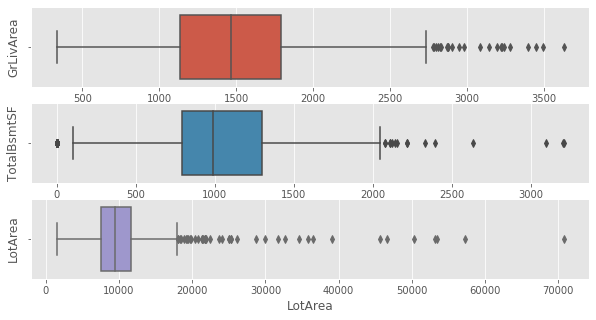

In [60]:
# Drop outliers from GrLivArea - this also accounts for the single large basement
df_train.drop(df_train.loc[df_train['GrLivArea']>4000].index,inplace=True)
# Drop large lot area outlier
df_train.drop(df_train.loc[df_train['LotArea']>100000].index,inplace=True)

# Box Plots of continuous variables following outlier removal
fig, ax = plt.subplots(3,1,figsize=(10,5))
_ = sns.boxplot(y='GrLivArea',data=df_train,ax=ax[0],orient='h',color=current_palette[0]).set_ylabel('GrLivArea')
_ = sns.boxplot(y='TotalBsmtSF',data=df_train,ax=ax[1],orient='h',color=current_palette[1]).set_ylabel('TotalBsmtSF')
_ = sns.boxplot(y='LotArea',data=df_train,ax=ax[2],orient='h',color=current_palette[2]).set_ylabel('LotArea')

In [61]:
# See how correlation with Sale Price has changed by removing outliers
old_correlation = log_train_correlation.loc[['GrLivArea','TotalBsmtSF','LotArea','TotRmsAbvGrd','FullBath','HalfBath']\
                                            ,'Log_Price_Correlation']
new_correlation = df_train[['GrLivArea','TotalBsmtSF','LotArea','TotRmsAbvGrd','FullBath','HalfBath','Log_SalePrice']].\
                                        corr()['Log_SalePrice']
new_correlation.drop('Log_SalePrice',inplace=True)

living_area_correlation = pd.concat([new_correlation,old_correlation],axis=1)
living_area_correlation.columns = ['Outliers Removed','Outliers Present']
display(living_area_correlation)

,Outliers Removed,Outliers Present
GrLivArea,0.726081,0.700520
TotalBsmtSF,0.651298,0.613459
LotArea,0.351068,0.260601
TotRmsAbvGrd,0.539076,0.537885
FullBath,0.595068,0.597066
HalfBath,0.316314,0.314718


In [75]:
df_train['TotalArea'] = df_train['GrLivArea'] + df_train['TotalBsmtSF']
df_train['TotalRooms'] = df_train['TotRmsAbvGrd'] + df_train['FullBath'] + df_train['HalfBath']
df_train['AvgRmSize'] = df_train['GrLivArea']/df_train['TotRmsAbvGrd']
X = df_train[['TotalArea','TotalRooms','AvgRmSize','Log_SalePrice']].corr()
X["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

display(X)

,TotalArea,TotalRooms,AvgRmSize,Log_SalePrice,VIF Factor
TotalArea,1.000000,0.715525,0.591807,0.825319,78.251211
TotalRooms,0.715525,1.000000,0.250616,0.619679,17.387072
AvgRmSize,0.591807,0.250616,1.000000,0.566565,8.771321
Log_SalePrice,0.825319,0.619679,0.566565,1.000000,37.874749
